## Projeto AirBnb Berlim/Alemanha - Prevendo o preço dos imóveis

#### Objetivo
Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não

### Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pathlib
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor

### Importando Bases de dados

In [2]:
semestres = {'pri': 1, 'seg': 2, 'ter': 3, 'qua': 4}

caminho_bases = pathlib.Path('basedados')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_semestre = arquivo.name[:3]
    semestre = semestres[nome_semestre]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['semestre'] = semestre 
    base_airbnb = base_airbnb.append(df)
    
display(base_airbnb)

id                                      listing_url  \
0                40218685            https://www.airbnb.com/rooms/40218685   
1                37849210            https://www.airbnb.com/rooms/37849210   
2                40218814            https://www.airbnb.com/rooms/40218814   
3                32431502            https://www.airbnb.com/rooms/32431502   
4      546874411676130505  https://www.airbnb.com/rooms/546874411676130505   
...                   ...                                              ...   
16675             2650812             https://www.airbnb.com/rooms/2650812   
16676            39853201            https://www.airbnb.com/rooms/39853201   
16677             2855881             https://www.airbnb.com/rooms/2855881   
16678            46313178            https://www.airbnb.com/rooms/46313178   
16679  602778194698740348  https://www.airbnb.com/rooms/602778194698740348   

            scrape_id last_scraped  \
0      20220320051227   2022-03-21   
1      20220320051227   2022-03-21   
2      20220320051227   2022-03-21   
3      20220320051227   2022-03-21   
4      20220320051227   2022-03-21   
...               ...          ...   
16675  20220915162225   2022-09-16   
16676  20220915162225   2022-09-16   
16677  20220915162225   2022-09-16   
16678  20220915162225   2022-09-16   
16679  20220915162225   2022-09-16   

                                                    name  \
0      Ap 4 - Schönes Apartment nahe dem Helios Klinikum   
1              MODERN APARTMENT AT THE BERLIN WALL TRAIL   
2        Ap 33 - Schöne Ferienwohnung am Helios Klinikum   
3      Marcella`s Ferienhaus  westl. Stadtrand zu Berlin   
4      Lake house getaway in nature reserve close to Bln   
...                                                  ...   
16675                           Gäste-Zimmer   ALEXA   2   
16676  3-Zi-Wohnung am  Dämeritzsee, Berlin, Brandenburg   
16677                             Gäste-Zimmer  ALEXA  4   
16678      TESLA / Grünheide Wohnung hochwertig möbliert   
16679      Moderne Souterrainwohnung mit großer Terrasse   

                                             description  \
0      Schwanenburg Apartments am Helios Klinikum - A...   
1      The location:<br />Right at the southern city ...   
2      Schwanenburg Apartments am Helios Klinikum - A...   
3      Das gemütliche Ferienhaus liegt am westlichen ...   
4      Take a break from the city in this cozy little...   
...                                                  ...   
16675  Für den angenehmen Aufenthalt haben wir ein Ei...   
16676  Die 112qm große 3-Raum-EG-Wohnung liegt direkt...   
16677  Unser Zuhause in Schönblick bietet zusätzlich ...   
16678  Tolle neue hochwertig Design-möblierte Wohnung...   
16679  Nah am See gelegen ist die Wohnung der perfekt...   

                                   neighborhood_overview  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3      Falkensee ist eine Gartenstadt mit viel Grün. ...   
4      Within 5 minutes walking distance you reach tw...   
...                                                  ...   
16675                                                NaN   
16676  Es ist eine ruhige Wohnstrasse, meist mit  Ein...   
16677  Der Ortsteil Schönblick in Woltersdorf (Schleu...   
16678  Sehr ruhige idyllische Straße mit netten Nachb...   
16679          Ruhige Wohngegend zwischen See und Wald 🌳   

                                             picture_url    host_id  \
0      https://a0.muscache.com/pictures/miso/Hosting-...   39450649   
1      https://a0.muscache.com/pictures/797e3d16-06e6...  286623313   
2      https://a0.muscache.com/pictures/miso/Hosting-...   39450649   
3      https://a0.muscache.com/pictures/2a3908bf-8393...  243598169   
4      https://a0.muscache.com/pictures/miso/Hosting-...  156670608   
...                                     

### Agora vamos começar os tratamentos - EDITAR COM MINHAS PALAVRAS

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [3]:
print(list(base_airbnb.columns))
#base_airbnb.to_csv('first_analise.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [4]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_identity_verified','latitude','longitude','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','ano','semestre']
#
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0          within an hour               100%                 f   
1      a few days or more                25%                 f   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4      within a few hours                75%                 f   
...                   ...                ...               ...   
16675  within a few hours               100%                 f   
16676  within a few hours               100%                 t   
16677  within a few hours               100%                 f   
16678        within a day                89%                 f   
16679      within an hour                90%                 t   

      host_identity_verified  latitude  longitude            property_type  \
0                          t  52.63136   13.51879             Holiday park   
1                          t  52.37272   13.41607       Entire rental unit   
2                          t  52.63136   13.51879       Entire rental unit   
3                          t  52.55720   13.14205  Entire residential home   
4                          t  52.45472   13.10890           Entire cottage   
...                      ...       ...        ...                      ...   
16675                      t  52.45776   13.72540     Private room in home   
16676                      t  52.41807   13.74173       Entire rental unit   
16677                      t  52.45965   13.72548     Private room in home   
16678                      t  52.46061   13.69917       Entire rental unit   
16679                      t  52.45520   13.75608       Entire rental unit   

             room_type  accommodates bathrooms_text  ...  \
0      Entire home/apt             2         1 bath  ...   
1      Entire home/apt             4         1 bath  ...   
2      Entire home/apt             4         1 bath  ...   
3      Entire home/apt             3         1 bath  ...   
4      Entire home/apt             5         1 bath  ...   
...                ...           ...            ...  ...   
16675     Private room             3         1 bath  ...   
16676  Entire home/apt             4         1 bath  ...   
16677     Private room             6         1 bath  ...   
16678  Entire home/apt             2         1 bath  ...   
16679  Entire home/apt             2         1 bath  ...   

       review_scores_rating  review_scores_accuracy review_scores_cleanliness  \
0                      4.45                    4.27                      4.91   
1                      5.00                    5.00                      5.00   
2                      4.33                    4.67                      4.67   
3                      4.81                    4.88                      4.69   
4                      5.00                    5.00                      5.00   
...                     ...                     ...                       ...   
16675                   NaN                     NaN                       NaN   
16676                  5.00                    5.00                      4.96   
16677                   NaN                     NaN                       NaN   
16678                   NaN                     NaN                       NaN   
16679                   NaN                     NaN                       NaN   

      review_scores_checkin  review_scores_communication  \
0                      4.55                         4.73   
1                      5.00                         5.00   
2                      5.00                         5.00   
3                      5.00                         5.00   
4                      5.00                         5.00   
...                     ...                          ...   
16675                   NaN                          NaN   
16676                  5.00                         5.00   
16677                   NaN                

### Tratamento de valores faltantes - ESCREVER COM MINHAS PALAVRAS

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 9.200 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 100 linhas) vamos excluir as linhas que contém dados NaN ACHO Q TEM Q APAGAR, NÃO SÃO TANTOS DADOS

In [5]:
print(base_airbnb.isnull().sum())

host_response_time             35306
host_response_rate             35306
host_is_superhost                 39
host_identity_verified            51
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms_text                    85
bedrooms                        5616
beds                            1486
amenities                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
review_scores_rating           12136
review_scores_accuracy         13252
review_scores_cleanliness      13244
review_scores_checkin          13298
review_scores_communication    13255
review_scores_location         13294
review_scores_value            13302
instant_bookable                   0
ano                                0
semestre                           0
dtype: int64


In [6]:
print(base_airbnb.shape)

(67348, 26)


In [7]:
# Excluindo colunas com valores ausentes maior que 5000 ==> DEIXEI OS bedrooms para tratar

for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 6000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost           39
host_identity_verified      51
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms_text              85
bedrooms                  5616
beds                      1486
amenities                    0
price                        0
minimum_nights               0
number_of_reviews            0
instant_bookable             0
ano                          0
semestre                     0
dtype: int64


#### Optei por colocar 1 quarto nos dados faltantes

In [8]:
#media_quartos = 1.0

#base_airbnb['bedrooms'] = base_airbnb['bedrooms'].fillna(media_quartos)

In [9]:
# Excluindo linhas com dados faltantes. Como não eram tantas linhas, optei por excluir

base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(60336, 17)
host_is_superhost         0
host_identity_verified    0
latitude                  0
longitude                 0
property_type             0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
price                     0
minimum_nights            0
number_of_reviews         0
instant_bookable          0
ano                       0
semestre                  0
dtype: int64


### Verificando o tipo de dados em cada coluna

In [10]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost          object
host_identity_verified     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
bathrooms_text             object
bedrooms                  float64
beds                      float64
amenities                  object
price                      object
minimum_nights              int64
number_of_reviews           int64
instant_bookable           object
ano                         int64
semestre                    int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                         f
host_identity_verified                                                    t
latitude                                                           52.63136
longitude                                                          13.51879
property_type                              

### Como o preço "price" está sendo reconhecido como objeto (ao invés de ser um float) é necessário mudar o tipo de variável da coluna.

In [11]:
# Price

base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float64, copy=False)

# Verificando os tipos

print(base_airbnb.dtypes)

host_is_superhost          object
host_identity_verified     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
bathrooms_text             object
bedrooms                  float64
beds                      float64
amenities                  object
price                     float64
minimum_nights              int64
number_of_reviews           int64
instant_bookable           object
ano                         int64
semestre                    int64
dtype: object


<ipython-input-11-a7ae002861e3>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')


### Análise Exploratória e Tratando Outliers

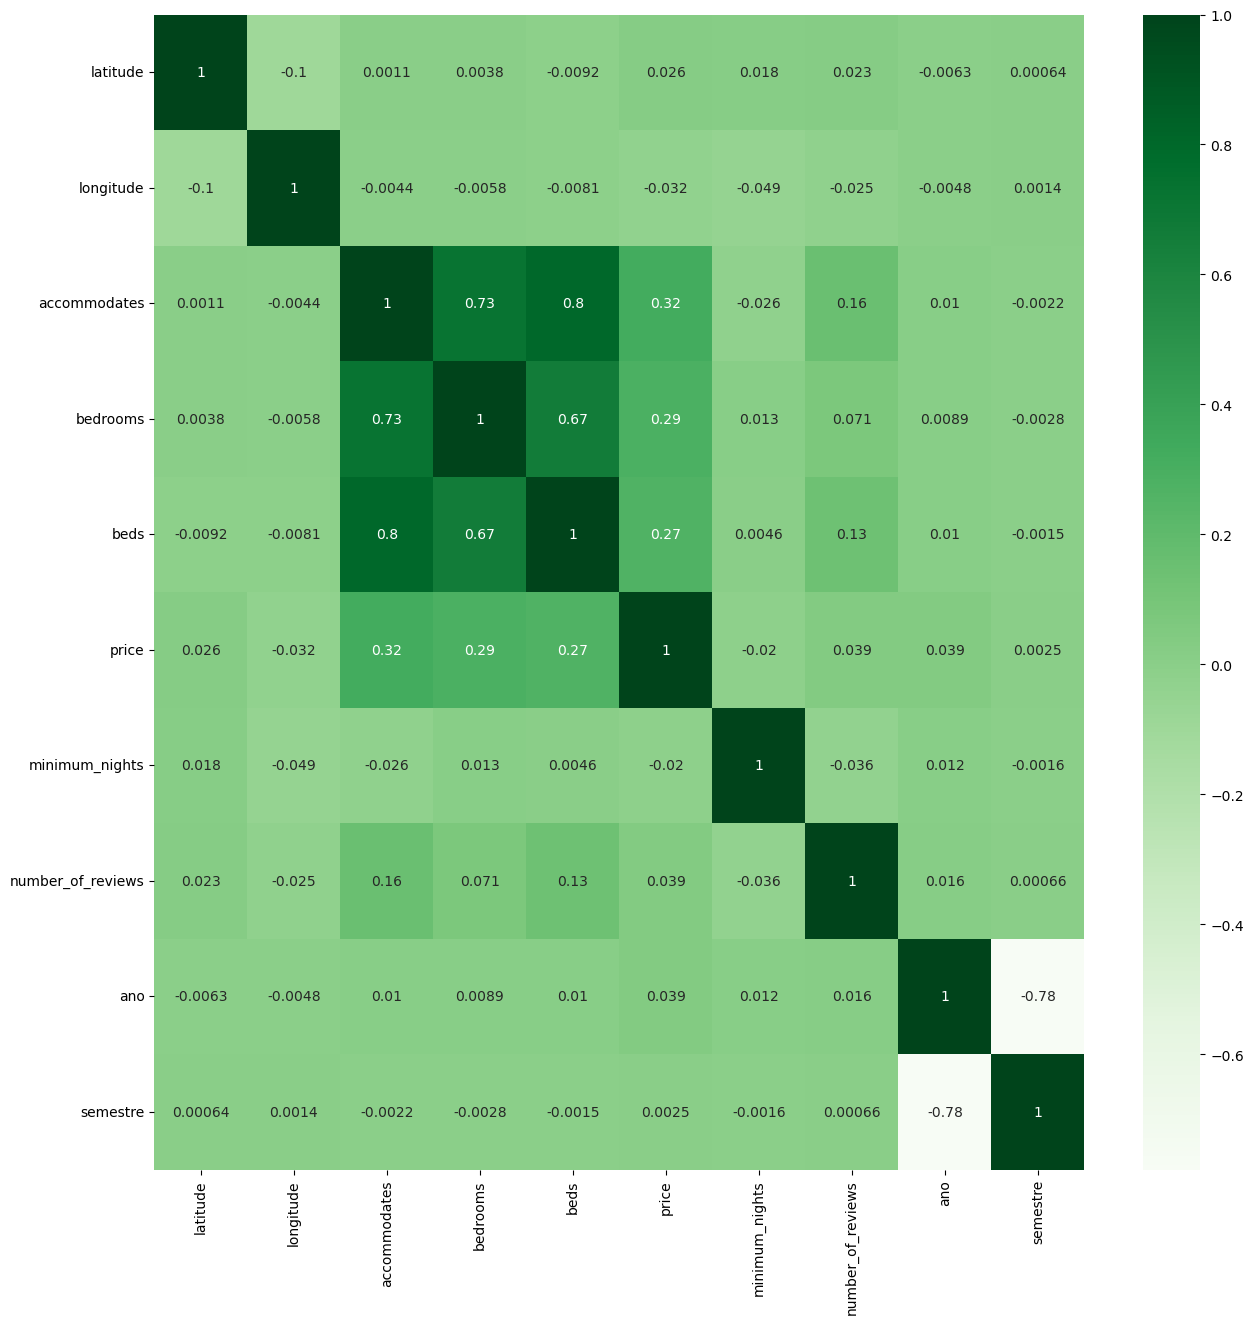

In [12]:
plt.figure(figsize=(15, 15))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')
plt.show()

### Definição de Funções para Análise de Outliers

Definindo algumas funções para ajudar na análise de outliers das colunas

In [13]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - (1.5 * amplitude), q3 + (1.5 * amplitude)

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

In [14]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Price

C:\Users\regis\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


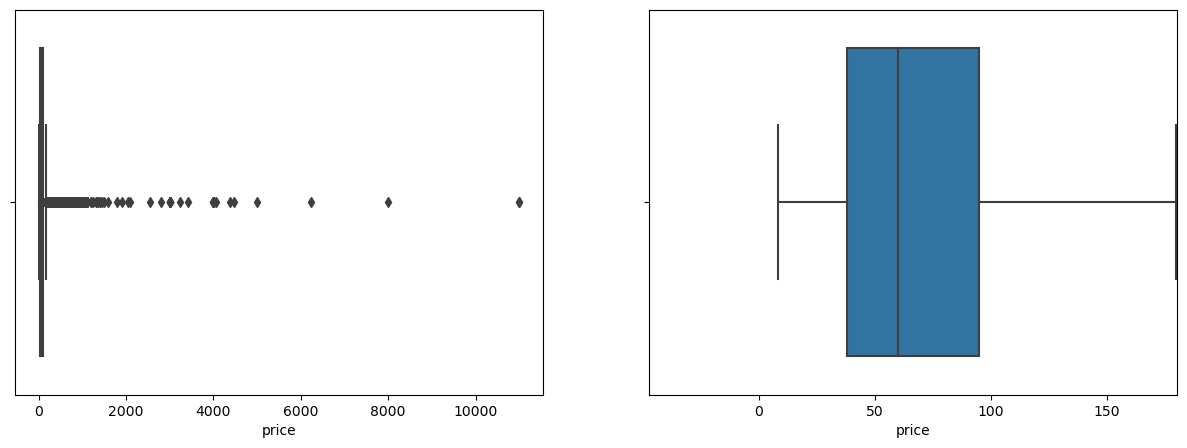

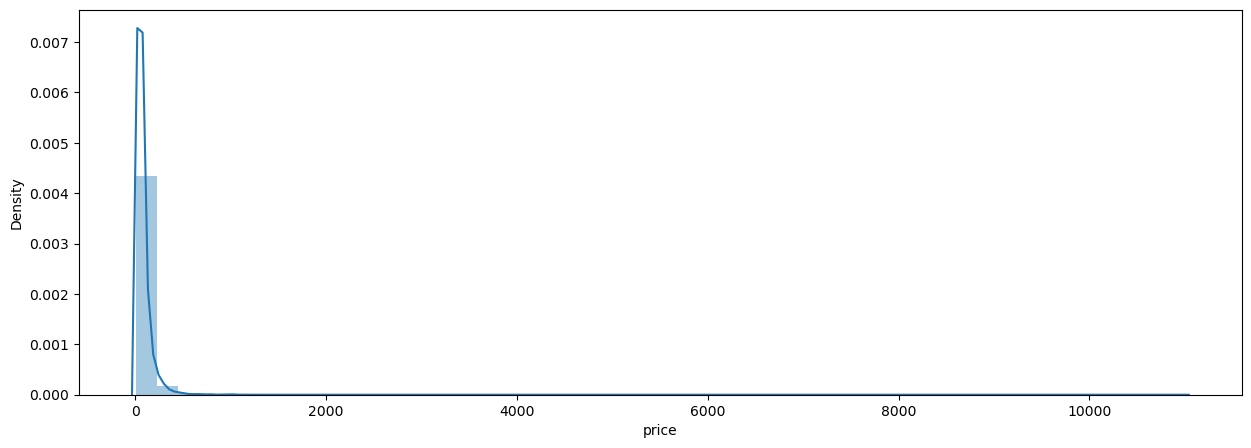

In [15]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])
plt.show()

In [16]:
#base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
#print('{} linhas removidas'.format(linhas_removidas))

base_airbnb = base_airbnb[(base_airbnb['price']>=22 ) & (base_airbnb['price'] <= 380)]
base_airbnb.head()

host_is_superhost host_identity_verified  latitude  longitude  \
0                 f                      t  52.63136   13.51879   
1                 f                      t  52.37272   13.41607   
2                 f                      t  52.63136   13.51879   
3                 f                      t  52.55720   13.14205   
4                 f                      t  52.45472   13.10890   

             property_type        room_type  accommodates bathrooms_text  \
0             Holiday park  Entire home/apt             2         1 bath   
1       Entire rental unit  Entire home/apt             4         1 bath   
2       Entire rental unit  Entire home/apt             4         1 bath   
3  Entire residential home  Entire home/apt             3         1 bath   
4           Entire cottage  Entire home/apt             5         1 bath   

   bedrooms  beds                                          amenities  price  \
0       1.0   1.0  ["Hair dryer", "Bed linens", "Stove", "Clothin...   51.0   
1       1.0   2.0  ["Bathtub", "Stove", "Patio or balcony", "Sing...   40.0   
2       2.0   3.0  ["Hair dryer", "Bed linens", "Bathtub", "Stove...   87.0   
3       1.0   4.0  ["Stove", "Patio or balcony", "Iron", "Single ...   55.0   
4       2.0   3.0  ["Hair dryer", "Carbon monoxide alarm", "Lockb...   90.0   

   minimum_nights  number_of_reviews instant_bookable   ano  semestre  
0               1                 11                t  2022         1  
1              28                  2                f  2022         1  
2               1                  3                t  2022         1  
3               3                 16                f  2022         1  
4               3                  4                f  2022         1

In [17]:
#base_airbnb.to_csv('analisando2.csv', sep=';')

### accommodates

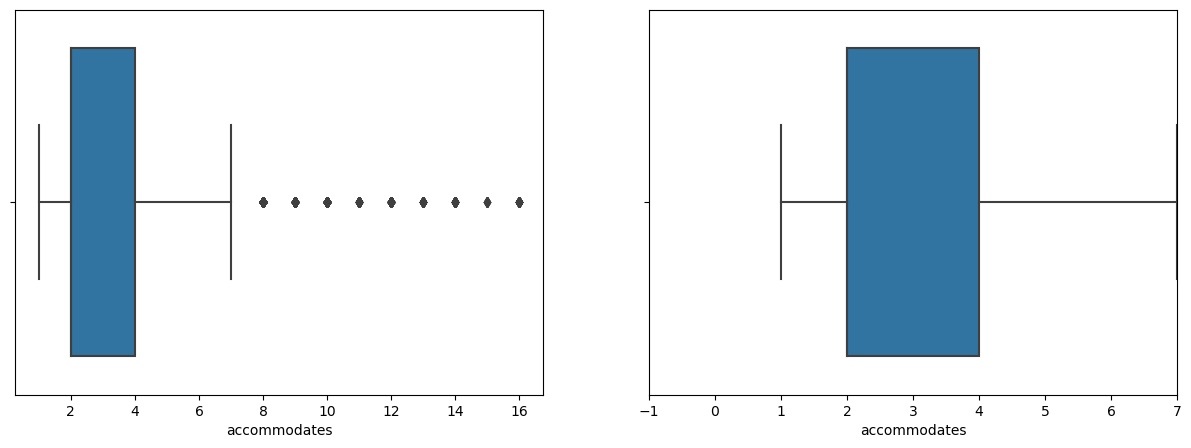

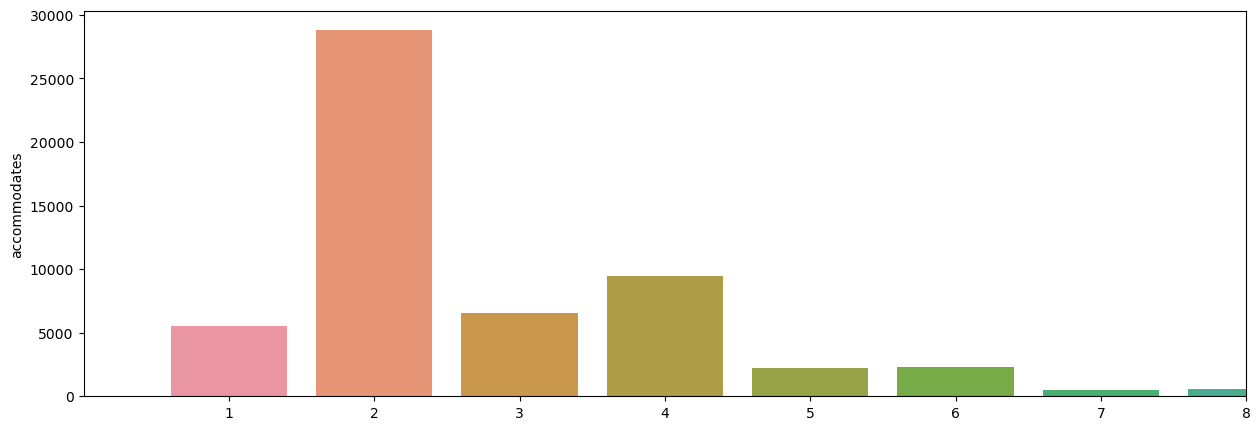

In [18]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])
plt.show()

In [19]:
#accommodates_max  = base_airbnb['accommodates'] <= 6
#base_airbnb_1 = base_airbnb[accommodates_max]

#base_airbnb_1.head()

base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

1114 linhas removidas


### bedrooms 

<ipython-input-14-36c0a219d88f>:5: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
<ipython-input-14-36c0a219d88f>:15: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(limites(coluna))


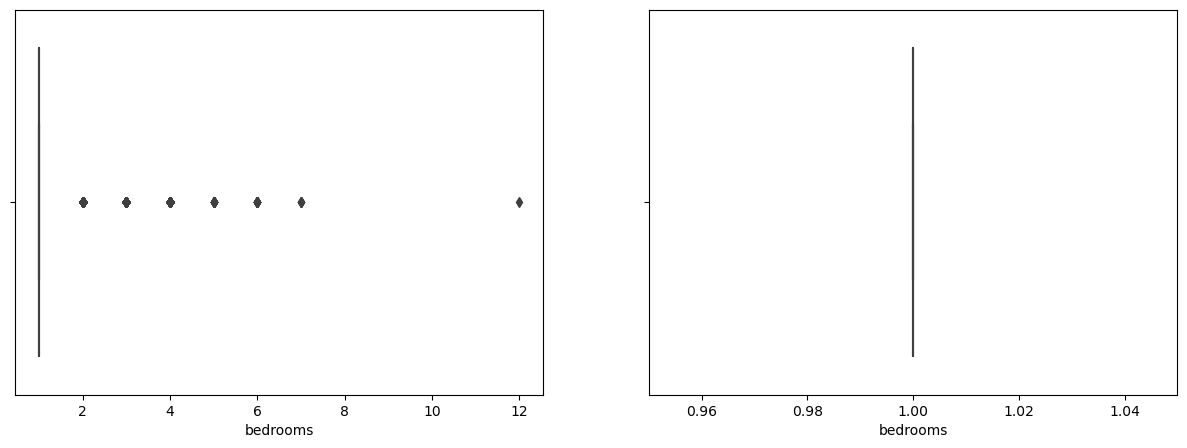

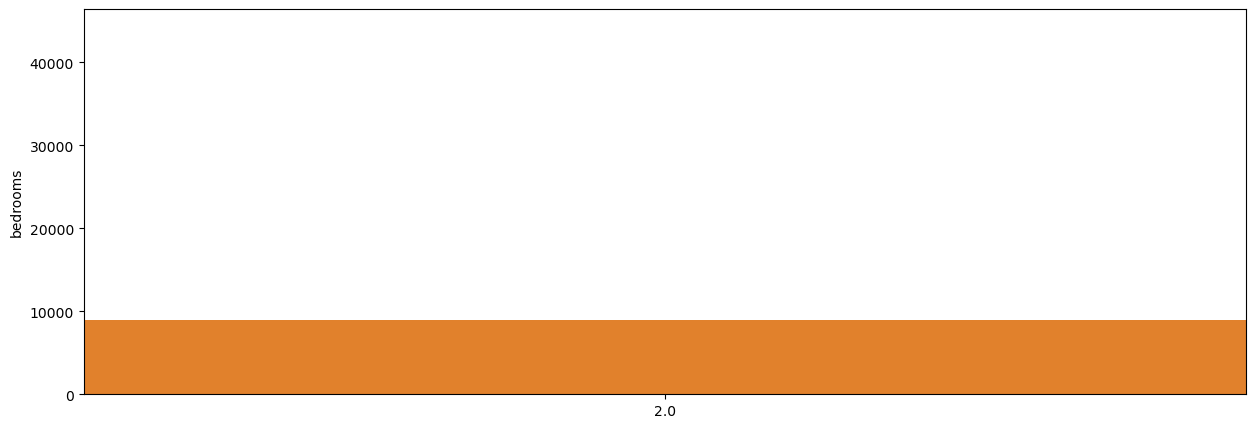

In [20]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])
plt.show()

In [21]:
#base_airbnb = base_airbnb.query("bedrooms <= 3")
#display(base_airbnb)

bedrooms_inf  = base_airbnb['bedrooms'] <= 3
base_airbnb_2 = base_airbnb[bedrooms_inf]

### beds

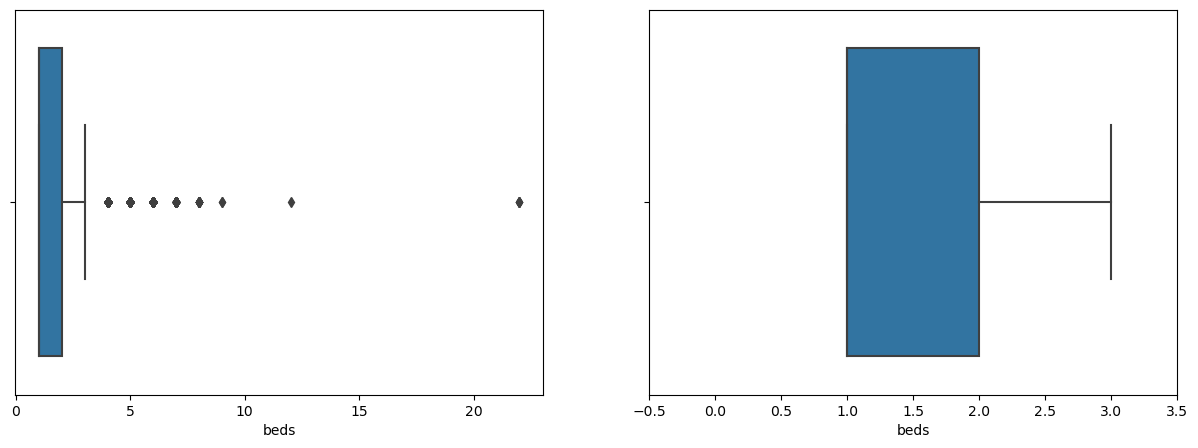

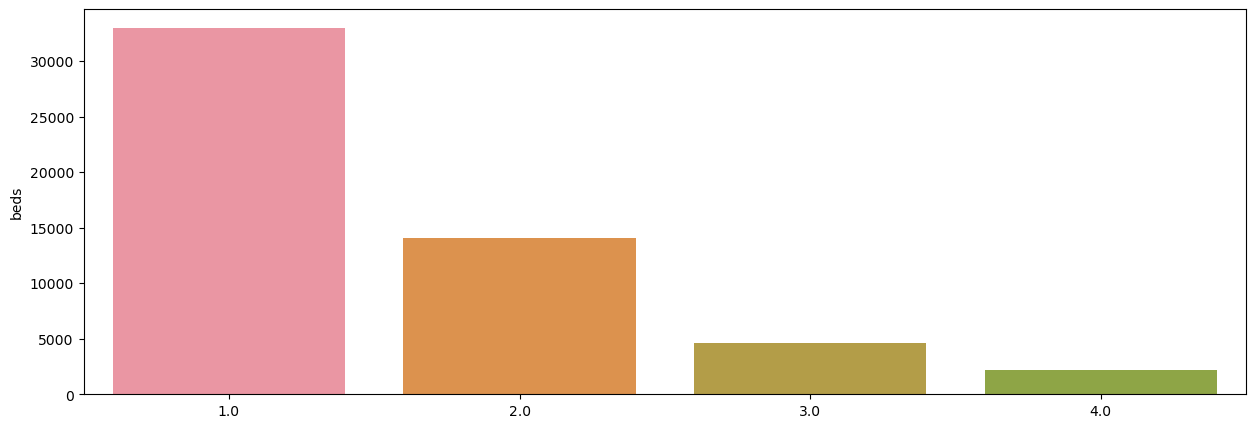

In [22]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])
plt.show()

In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))



3627 linhas removidas


### minimum_nights

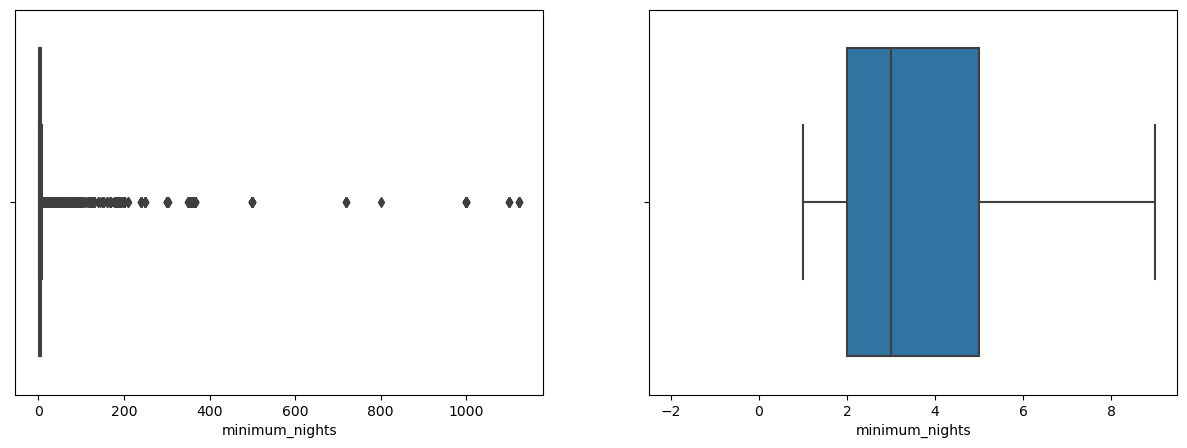

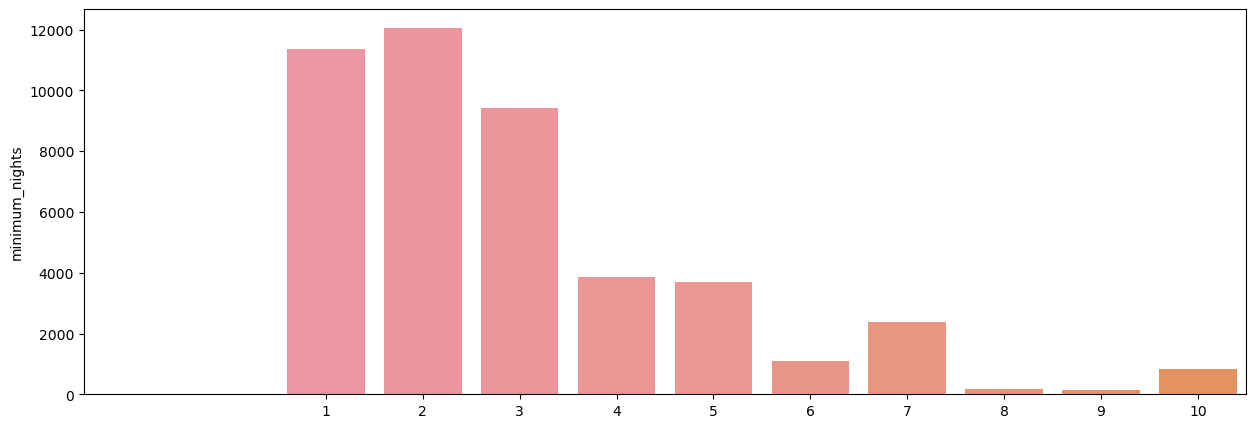

In [24]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])
plt.show()

In [25]:
min_nigh  = base_airbnb['minimum_nights'] <= 2
base_airbnb_2 = base_airbnb[min_nigh]

base_airbnb_2.head()

host_is_superhost host_identity_verified  latitude  longitude  \
0                 f                      t  52.63136   13.51879   
2                 f                      t  52.63136   13.51879   
5                 f                      t  52.63136   13.51879   
6                 f                      t  52.63150   13.51887   
8                 f                      t  52.45668   13.70262   

        property_type        room_type  accommodates bathrooms_text  bedrooms  \
0        Holiday park  Entire home/apt             2         1 bath       1.0   
2  Entire rental unit  Entire home/apt             4         1 bath       2.0   
5  Entire rental unit  Entire home/apt             4         1 bath       2.0   
6  Entire rental unit  Entire home/apt             2         1 bath       1.0   
8  Entire rental unit  Entire home/apt             2         1 bath       2.0   

   beds                                          amenities  price  \
0   1.0  ["Hair dryer", "Bed linens", "Stove", "Clothin...   51.0   
2   3.0  ["Hair dryer", "Bed linens", "Bathtub", "Stove...   87.0   
5   3.0  ["Hair dryer", "Bed linens", "Stove", "Clothin...   87.0   
6   2.0  ["Hair dryer", "Bed linens", "Stove", "Clothin...   75.0   
8   3.0  ["Hair dryer", "Bed linens", "Stove", "Free wa...   89.0   

   minimum_nights  number_of_reviews instant_bookable   ano  semestre  
0               1                 11                t  2022         1  
2               1                  3                t  2022         1  
5               1                  2                t  2022         1  
6               1                  5                t  2022         1  
8               2                 57                f  2022         1

### number_of_reviews

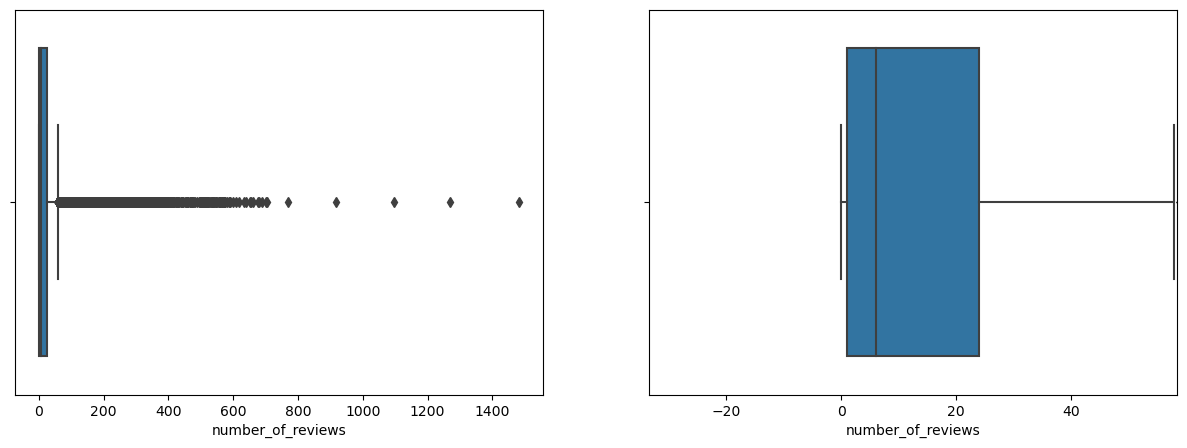

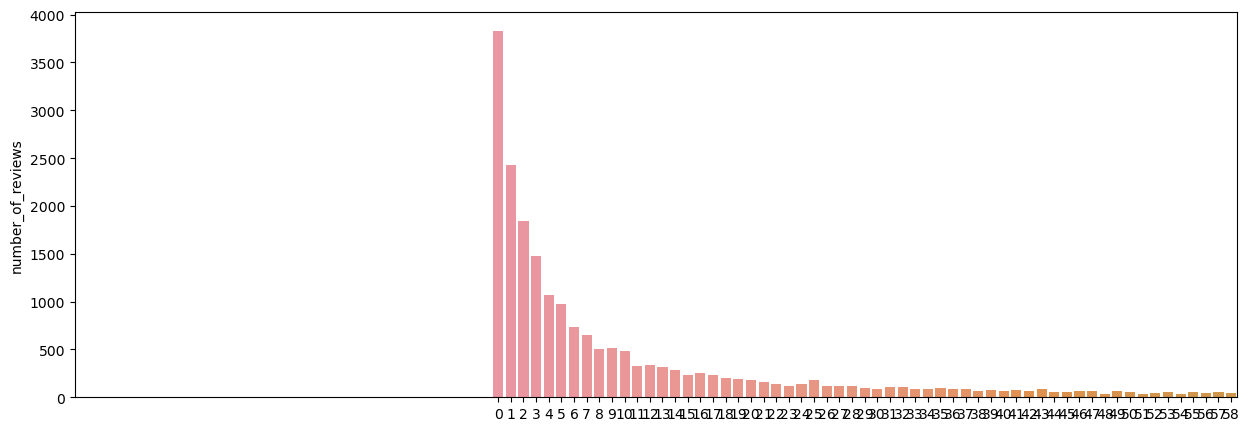

In [26]:
diagrama_caixa(base_airbnb_2['number_of_reviews'])
grafico_barra(base_airbnb_2['number_of_reviews'])
plt.show()

### Tratamento de Colunas de Valores de Texto

### property_type 

Private room in rental unit          10071
Entire rental unit                    8574
Room in hotel                          602
Entire serviced apartment              544
Private room in residential home       288
                                     ...  
Shared room                              2
Shared room in serviced apartment        2
Shared room in home                      1
Private room in minsu                    1
Holiday park                             1
Name: property_type, Length: 63, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


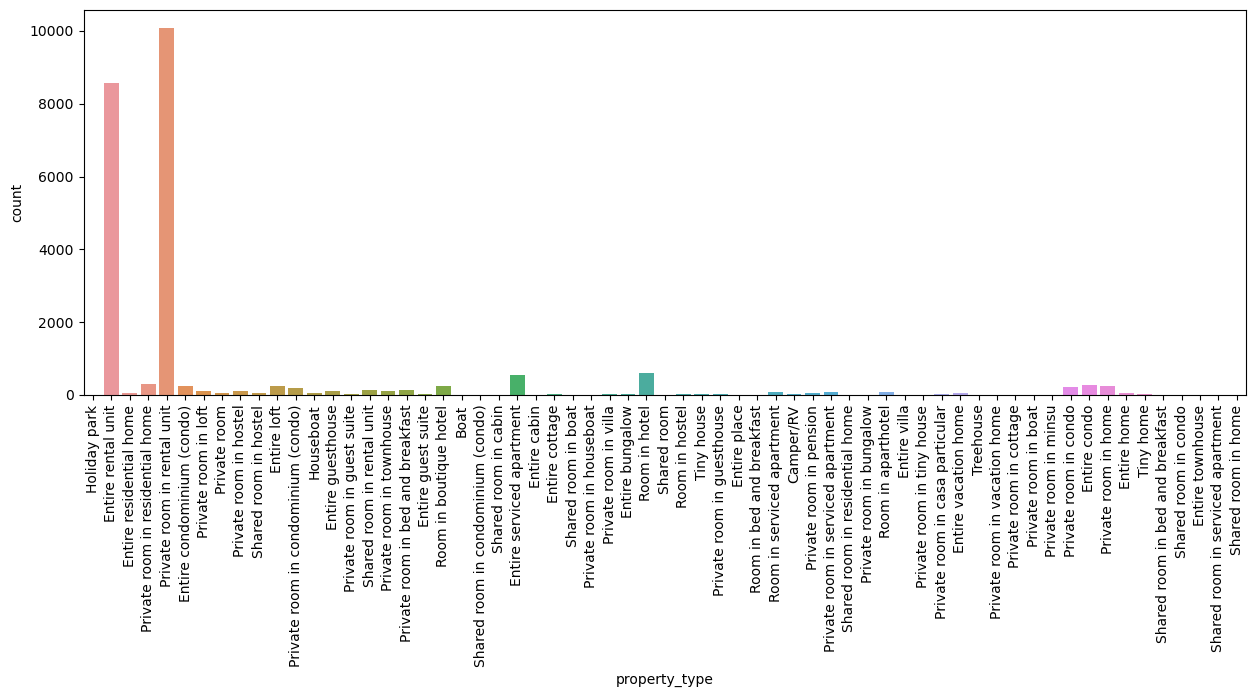

In [27]:
print(base_airbnb_2['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90) # para deixar todos os títulos na vertical
plt.show()

['Private room in residential home', 'Entire condo', 'Room in boutique hotel', 'Private room in home', 'Entire loft', 'Entire condominium (condo)', 'Private room in condo', 'Private room in condominium (condo)', 'Private room in bed and breakfast', 'Shared room in rental unit', 'Private room in hostel', 'Private room in loft', 'Private room in townhouse', 'Entire guesthouse', 'Room in aparthotel', 'Private room in serviced apartment', 'Room in serviced apartment', 'Private room', 'Entire home', 'Entire vacation home', 'Shared room in hostel', 'Entire residential home', 'Houseboat', 'Private room in pension', 'Entire bungalow', 'Entire guest suite', 'Room in hostel', 'Private room in villa', 'Private room in casa particular', 'Tiny home', 'Private room in guest suite', 'Camper/RV', 'Tiny house', 'Private room in guesthouse', 'Entire cottage', 'Private room in vacation home', 'Private room in bungalow', 'Boat', 'Entire cabin', 'Private room in houseboat', 'Private room in boat', 'Private

C:\Users\regis\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


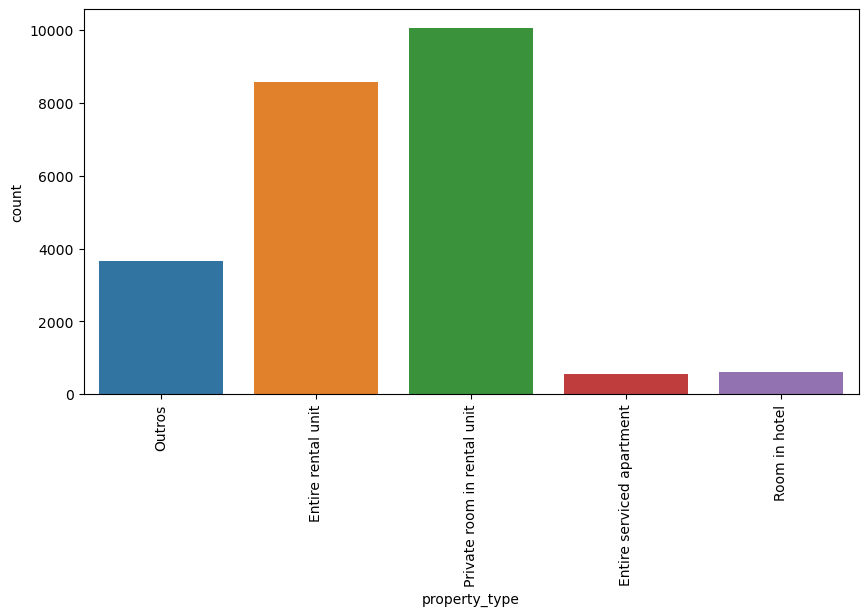

In [28]:
tabela_tipos_casa = base_airbnb_2['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 500:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_2.loc[base_airbnb_2['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb_2['property_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot('property_type', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90)
plt.show()

## room_type 

Private room       12404
Entire home/apt    10438
Hotel room           392
Shared room          209
Name: room_type, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


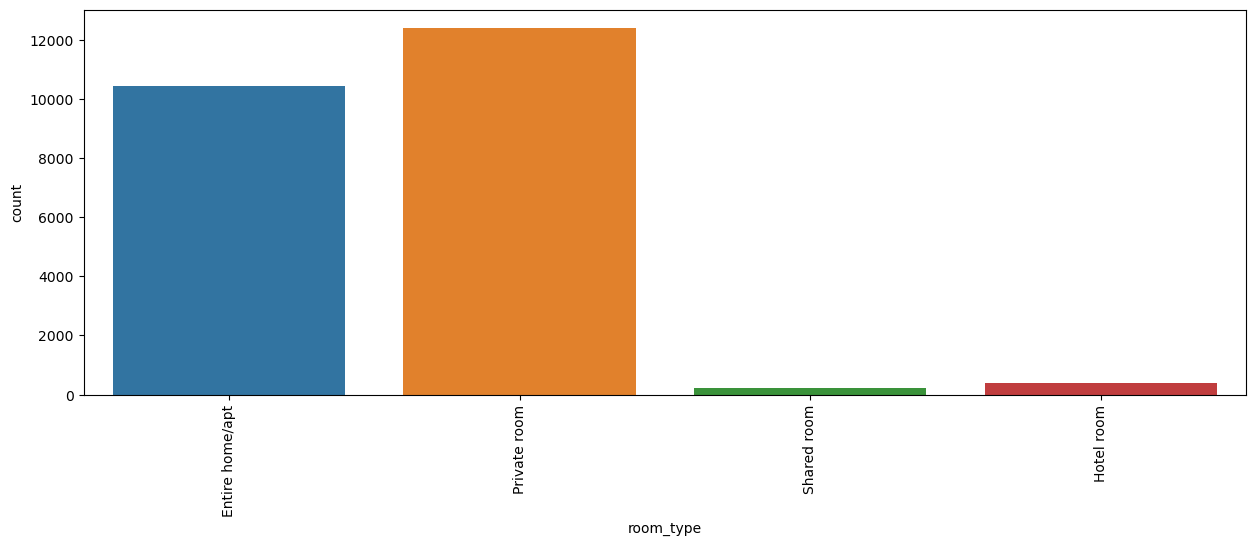

In [29]:
print(base_airbnb_2['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90) # para deixar todos os títulos na vertical
plt.show()

['Hotel room', 'Shared room']
Private room       12404
Entire home/apt    10438
Outros               601
Name: room_type, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


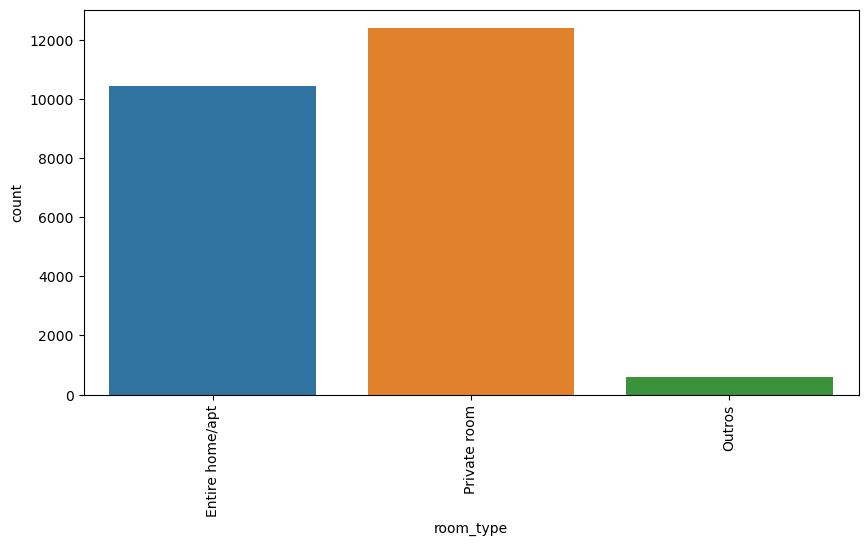

In [30]:
tabela_tipos_banheiro = base_airbnb_2['room_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_banheiro.index:
    if tabela_tipos_banheiro[tipo] < 500:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_2.loc[base_airbnb_2['room_type']==tipo, 'room_type'] = 'Outros'

print(base_airbnb_2['room_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot('room_type', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90)
plt.show()

- Como há apenas 4 tipos de 'room_type', optei por mantê-las

### amenities  

- Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo. EDITAR

In [31]:
print(base_airbnb_2['amenities'].iloc[1].split(','))
print(len(base_airbnb_2['amenities'].iloc[1].split(',')))

base_airbnb_2['n_amenities'] = base_airbnb_2['amenities'].str.split(',').apply(len)

['["Hair dryer"', ' "Bed linens"', ' "Bathtub"', ' "Stove"', ' "Oven"', ' "Patio or balcony"', ' "Free washer \\u2013 In building"', ' "Clothing storage: wardrobe"', ' "Security cameras on property"', ' "Dining table"', ' "Lockbox"', ' "Long term stays allowed"', ' "Baking sheet"', ' "Free parking on premises"', ' "Refrigerator"', ' "Free street parking"', ' "Cooking basics"', ' "Heating"', ' "Wifi"', ' "Microwave"', ' "Dedicated workspace"', ' "Coffee maker"', ' "Smoke alarm"', ' "Luggage dropoff allowed"', ' "Hangers"', ' "Extra pillows and blankets"', ' "Essentials"', ' "Hot water kettle"', ' "Hot water"', ' "TV"', ' "Private entrance"', ' "Kitchen"', ' "Dishes and silverware"]']
33


<ipython-input-31-c97141596607>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_airbnb_2['n_amenities'] = base_airbnb_2['amenities'].str.split(',').apply(len)


In [32]:
base_airbnb_2 = base_airbnb_2.drop('amenities', axis=1)
base_airbnb_2.shape

(23443, 17)

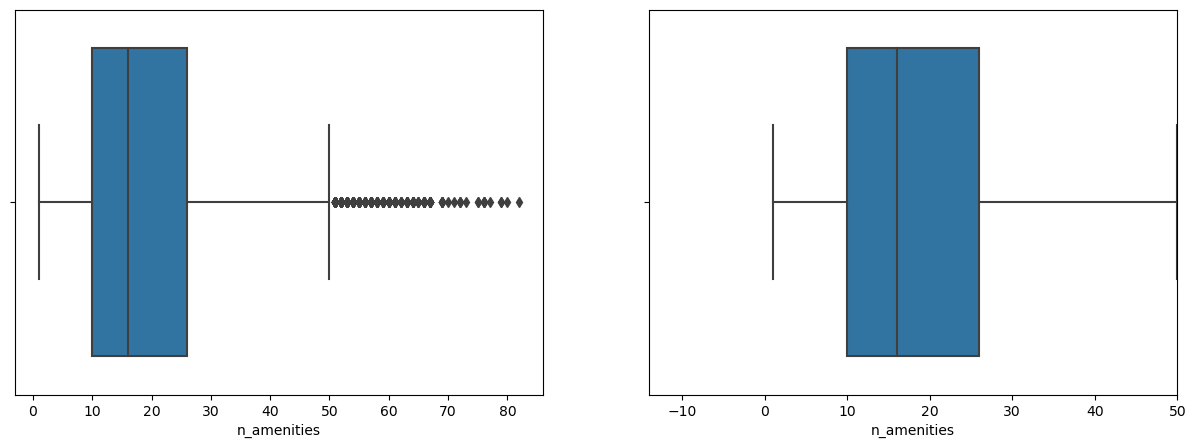

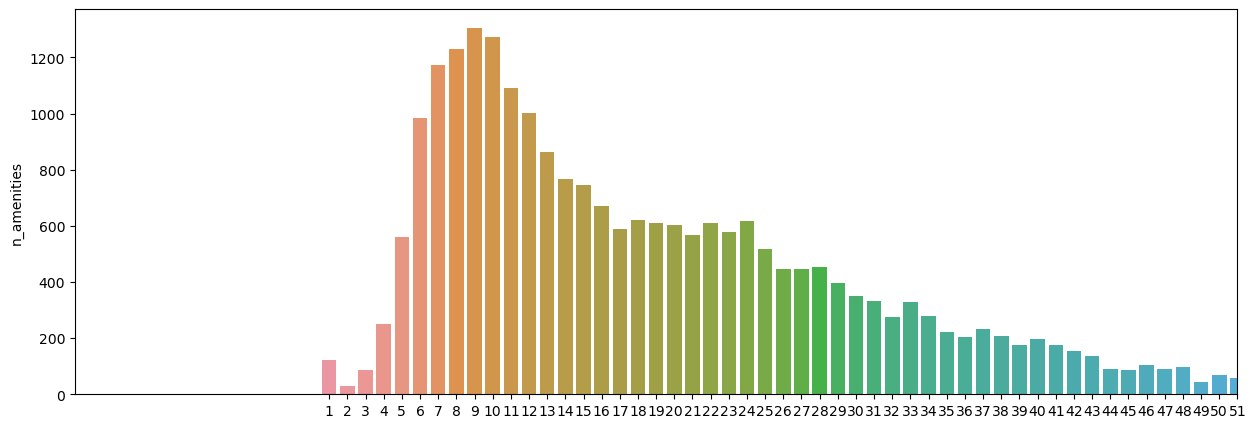

In [33]:
diagrama_caixa(base_airbnb_2['n_amenities'])
grafico_barra(base_airbnb_2['n_amenities'])
plt.show()

- Então, essa virou uma coluna de valor numérico e, como todas as outras colunas de valores numéricos, eu exclui outliers com os mesmos modelos anteriores EDITAR

In [34]:
base_airbnb_2, linhas_removidas = excluir_outliers(base_airbnb_2, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

392 linhas removidas


### bathrooms_text

1 bath               11838
1 shared bath         6850
1 private bath        1854
1.5 baths              778
1.5 shared baths       641
2 baths                478
2 shared baths         338
2.5 baths               60
Half-bath               55
0 shared baths          54
2.5 shared baths        26
0 baths                 24
Shared half-bath        23
3 baths                 11
Private half-bath        5
4 baths                  4
8 baths                  4
7 baths                  4
4.5 shared baths         3
4 shared baths           1
Name: bathrooms_text, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


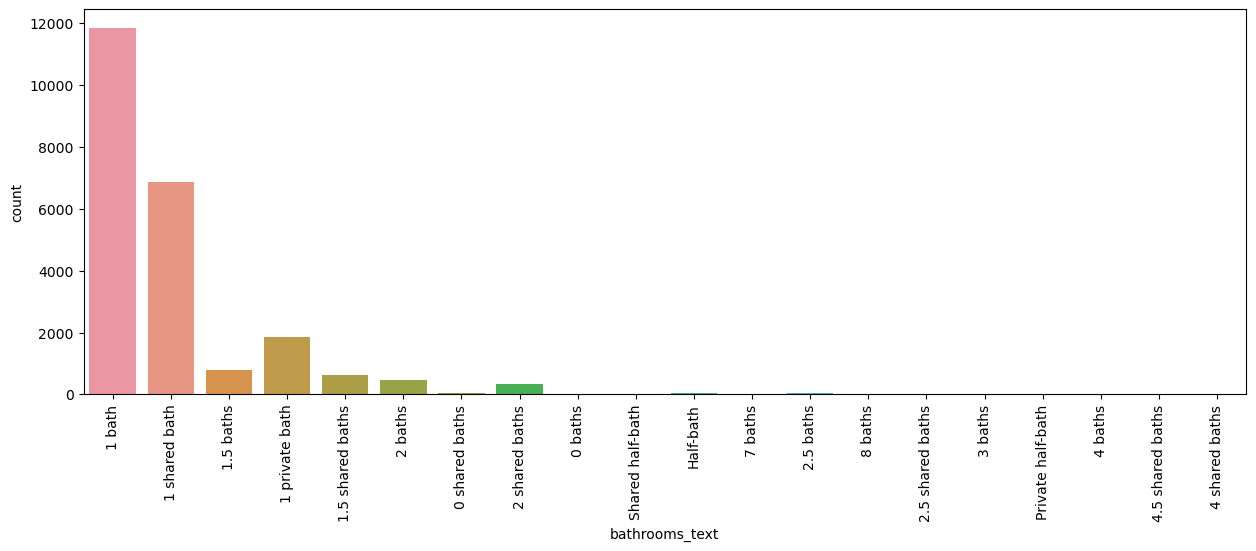

In [35]:
print(base_airbnb_2['bathrooms_text'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bathrooms_text', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90) # para deixar todos os títulos na vertical
plt.show()

['2 baths', '2 shared baths', '2.5 baths', 'Half-bath', '0 shared baths', '2.5 shared baths', '0 baths', 'Shared half-bath', '3 baths', 'Private half-bath', '4 baths', '8 baths', '7 baths', '4.5 shared baths', '4 shared baths']
1 bath              11838
1 shared bath        6850
1 private bath       1854
Outros               1090
1.5 baths             778
1.5 shared baths      641
Name: bathrooms_text, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


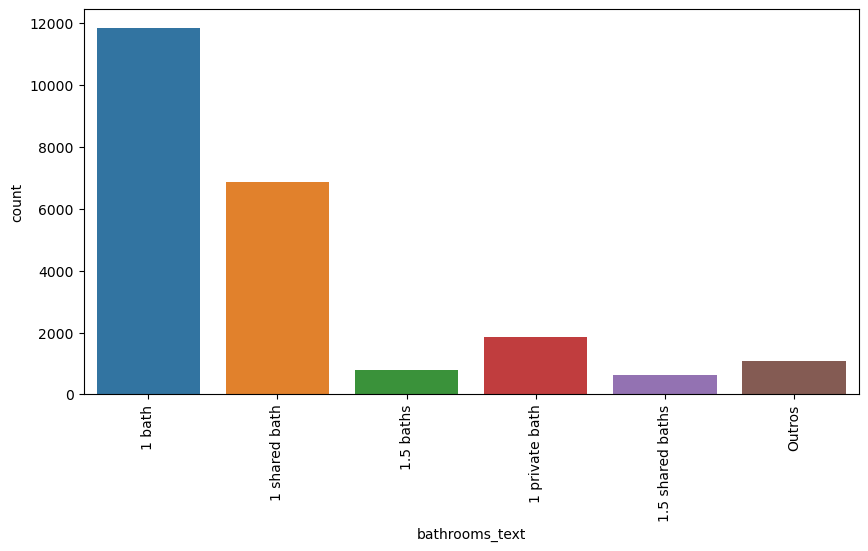

In [36]:
tabela_tipos_banheiro = base_airbnb_2['bathrooms_text'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_banheiro.index:
    if tabela_tipos_banheiro[tipo] < 500:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_2.loc[base_airbnb_2['bathrooms_text']==tipo, 'bathrooms_text'] = 'Outros'

print(base_airbnb_2['bathrooms_text'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot('bathrooms_text', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90)
plt.show()

### Visualização de Mapa das Propriedades


Vamos criar um mapa que exibe um pedaço da nossa base de dados aleatório (10.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [37]:
amostra = base_airbnb_2.sample(n=10000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=3.5,
                        center=centro_mapa, zoom=11,
                       mapbox_style='stamen-terrain')
mapa.show()

### Encoding

Ajustando as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.) EDITAR

- Features de Valores True ou False, substití True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) utilizei o método de encoding de variáveis dummies

In [38]:
colunas_tf = ['host_is_superhost', 'host_identity_verified', 'instant_bookable'] # 
base_airbnb_cod = base_airbnb_2.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [39]:
colunas_categorias = ['property_type','room_type', 'bathrooms_text'] # 

base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

host_is_superhost host_identity_verified  latitude  longitude  accommodates  \
0                 0                      1  52.63136   13.51879             2   
2                 0                      1  52.63136   13.51879             4   
5                 0                      1  52.63136   13.51879             4   
6                 0                      1  52.63150   13.51887             2   
8                 0                      1  52.45668   13.70262             2   

   bedrooms  beds  price  minimum_nights  number_of_reviews  ...  \
0       1.0   1.0   51.0               1                 11  ...   
2       2.0   3.0   87.0               1                  3  ...   
5       2.0   3.0   87.0               1                  2  ...   
6       1.0   2.0   75.0               1                  5  ...   
8       2.0   3.0   89.0               2                 57  ...   

  property_type_Room in hotel  room_type_Entire home/apt  room_type_Outros  \
0                           0                          1                 0   
2                           0                          1                 0   
5                           0                          1                 0   
6                           0                          1                 0   
8                           0                          1                 0   

   room_type_Private room  bathrooms_text_1 bath  \
0                       0                      1   
2                       0                      1   
5                       0                      1   
6                       0                      1   
8                       0                      1   

   bathrooms_text_1 private bath  bathrooms_text_1 shared bath  \
0                              0                             0   
2                              0                             0   
5                              0                             0   
6                              0                             0   
8                              0                             0   

   bathrooms_text_1.5 baths  bathrooms_text_1.5 shared baths  \
0                         0                                0   
2                         0                                0   
5                         0                                0   
6                         0                                0   
8                         0                                0   

   bathrooms_text_Outros  
0                      0  
2                      0  
5                      0  
6                      0  
8                      0  

[5 rows x 28 columns]

### Modelo de Previsão

- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

In [40]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

Assim, escolhemos esses 3 modelos. Existem dezenas, ou até centenas de modelos diferentes. A medida com que você for aprendendo mais e mais sobre Ciência de Dados, você vai aprender sempre novos modelos e entendendo aos poucos qual o melhor modelo para usar em cada situação.

Mas na dúvida, esses 3 modelos que usamos aqui são bem bons para muitos problemas de Regressão. EDITAR

In [41]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()
modelo_dt = DecisionTreeRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          'Decision tree': modelo_dt
           }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

- Separando os dados em treino e teste + Treino do Modelo

Essa etapa é crucial. As Inteligências Artificiais aprendendo com o que chamamos de treino.

Basicamente o que a gente faz é: a gente separa as informações em treino e teste, ex: 10% da base de dados vai servir para teste e 90% para treino (normalmente treino é maior mesmo)

Aí, damos para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços.

Depois que ele aprende, você faz um teste com ele, com os dados de teste, para ver se ela está bom ou não. Analisando os dados de teste você descobre o melhor modelo EDITAR

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:82.22%
RSME:22.76
Modelo LinearRegression:
R²:41.61%
RSME:41.24
Modelo ExtraTrees:
R²:80.23%
RSME:24.00
Modelo Decision tree:
R²:60.34%
RSME:33.99


### Análise do Melhor Modelo

In [43]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:82.22%
RSME:22.76
Modelo LinearRegression:
R²:41.61%
RSME:41.24
Modelo ExtraTrees:
R²:80.23%
RSME:24.00
Modelo Decision tree:
R²:60.34%
RSME:33.99


- Modelo Escolhido como Melhor Modelo: RandomForest 

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de ExtraTrees (que teve resultados próximos de R² e RSME), escolhi o Modelo RandomForest .
    
    Os outros modelos não tiveram um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliação no Modelo Vencedor:<br>
Modelo RandomForest :<br>
R²: 82.63% <br>
RSME: 22.49

### Ajustes e melhorias

0
property_type_Private room in rental unit  0.196874
latitude                                   0.124797
longitude                                  0.119535
n_amenities                                0.096507
number_of_reviews                          0.069658
property_type_Entire serviced apartment    0.064578
accommodates                               0.062645
semestre                                   0.044429
bathrooms_text_1 bath                      0.025166
property_type_Room in hotel                0.017376
room_type_Outros                           0.017137
bathrooms_text_1 private bath              0.015886
host_is_superhost                          0.015232
instant_bookable                           0.014490
minimum_nights                             0.014319
beds                                       0.014142
bathrooms_text_1 shared bath               0.014033
bedrooms                                   0.012652
ano                                        0.012608
host_identity_verified                     0.009211
room_type_Private room                     0.007725
property_type_Outros                       0.006642
bathrooms_text_1.5 baths                   0.006018
property_type_Entire rental unit           0.005801
bathrooms_text_Outros                      0.005792
room_type_Entire home/apt                  0.004758
bathrooms_text_1.5 shared baths            0.001989

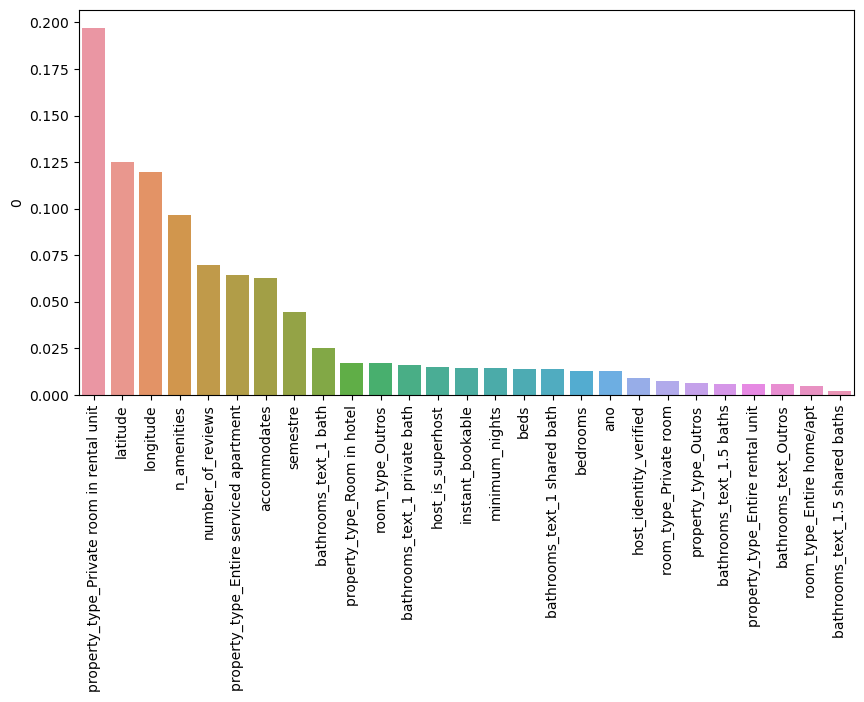

In [44]:
importancia_features = pd.DataFrame(modelo_rf.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)
plt.show()

# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)<br>
- Passo 2 -> Escolher a forma de deploy:
    - Arquivo Executável + Tkinter
    - Deploy em Microsite (Flask)
    - Deploy apenas para uso direto Streamlit
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [45]:
X['price'] = y
X.to_csv('dados.csv')

In [46]:
import joblib
joblib.dump(modelo_rf, 'modelo.joblib')

['modelo.joblib']